In [11]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import rv_continuous
from astroquery.gaia import Gaia

In [21]:
# Define some distribution for the priors
# Uniform prior has already built-in scipy.stats.uniform

# Constant Volume Density
class ConstantDensity_gen(rv_continuous):
    r"""A constant density continuous random variable.

    In the standard form, the distribution is proportional to r^2 on ``[0, 1]``. Using
    the parameters ``loc`` and ``scale``, one obtains the distribution
    on ``[loc, loc + scale]``.
    """
    def _pdf(self, x):
        return 3*np.power(x, 2)

    def _logpdf(self, x):
        return np.log(3)+2*np.log(x)

    def _cdf(self, x):
        return np.power(x, 3)
    
    def _logcdf(self, x):
        return 3*np.log(x)

    def _ppf(self, x):
        return np.power(x, 1/3)

    def __sf(self, x):
        return 1 - np.power(x, 3)

    def _logsf(self, x):
        return np.log(1 - np.power(x, 3))
    
    def _isf(self, x):
        return np.power(1-x, 1/3)
        
constantDensity = ConstantDensity_gen(a=0.0, b=1.0, name='constant_density')

# # Exponentially Decreasing
class ExponentiallyDecreasing_gen(rv_continuous):
    r"""An exponentially decreasing continuous random variable.

    The location (``loc``) keyword specifies the zero-distance.
    The scale (``scale``) keyword specifies the scale length.

    %(before_notes)s

    Notes
    -----
    The probability density function for `exponentially decreasing` is:

    .. math::

        f(x) = \frac{x^2\exp(-x/L)}{3L^{3}}

    for a positive real number :math:`x` 
    and positive real number :math:`x`.

    %(after_notes)s
    """
    def _pdf(self, x):
        return np.exp(-x)*np.power(x, 2)/3

    def _logpdf(self, x):
        return 2*np.log(x)-x-np.log(3)

    def _cdf(self, x):
        return 1/3*(2-np.exp(-x)*(x*(x+2)+2))
    
    def _logcdf(self, x):
        return np.log((2-np.exp(-x)*(x*(x+2)+2))) - np.log(3)
        
exponentiallyDecreasing = ExponentiallyDecreasing_gen(a=0.0, name='exponentially_decreasing')

In [13]:
# Grab data from Gaia DR2
job = Gaia.launch_job_async(""" 
SELECT TOP 100 *
FROM gaiadr2.gaia_source
WHERE parallax > 0 AND (random_index BETWEEN 12345 AND 56789)
""")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [14]:
# Check what's in r
r

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object
1635721458409799680,Gaia DR2 2027838817078343808,2027838817078343808,12348,2015.5,296.17963761795744,0.06622338039938398,26.616150577358916,0.11085936767290068,0.43243125624106177,0.12165888759411657,3.5544567,-2.514464881154338,0.15810315513126771,-8.40324780611779,0.2218156823023576,-0.2534772,-0.14235218,-0.1578416,0.1635482,0.16984342,0.09576408,-0.5437369,-0.2031776,0.032690432,-0.14140934,307,0,307,0,0.76893926,320.60043,0.0,0.0,31,False,1.2473869,1.426229149824806,0.02057512902894544,0.031403486,35,15,0.21201316,0,37,False,322,1453.1294723194594,1.5388593232681809,944.29,17.782604,35,470.6735675063918,7.851031009061963,59.950542,18.669588,34,1493.2875112392178,6.780554844840095,220.23087,16.826561,1.3515389,0,1.8430271,0.8869839,0.95604324,--,--,0,--,--,--,NOT_AVAILABLE,62.45374518855046,1.2015080102851974,305.2601792119767,46.90184919788637,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+2027838817078343808
1635721458409799680,Gaia DR2 4161933574533589888,4161933574533589888,12350,2015.5,266.3668799411112,1.6173675985877443,-12.731826391678128,2.36699118717473,3.264891413120491,3.362813363303925,0.9708809,-4.28034758583191,3.2988442130305686,-1.9951465969901372,2.767448524924499,0.5325933,-0.5273239,0.32865846,-0.0913

In [26]:
# Init Data, just change the index as you like
index = int(input()) 
# index = 50
parallax = r["parallax"][index]/1000
parallax_error = r["parallax_error"][index]/1000

# Preliminary 
## Trust me, rmax = 15_000 pc is reasonable
rmax = 1.5E4
distance = np.linspace(1, rmax, 1000)
## Likelihood function, see Bailer-Jones
likelihood = norm.pdf(x=1/distance, scale=parallax_error, loc=parallax)
normalization, _ = integrate.quad(lambda t: norm.pdf(x=1/t, scale=parallax_error, loc=parallax), a=0, b=rmax)
likelihood /= normalization

# Prior 1, Uniform
prior1 = uniform.pdf(x=distance, scale=rmax)
posterior1 = prior1*likelihood
posterior1_norm = integrate.simps(posterior1, distance)
posterior1 /= posterior1_norm

# Prior 2, Constant Volume Density
prior2 = constantDensity.pdf(x=distance, scale=rmax)
posterior2 = prior2*likelihood
posterior2_norm = integrate.simps(posterior2, distance)
posterior2 /= posterior2_norm

# Prior 3, Exponentially Decreasing
## scale length 1_000, seems reasonable
rlen = 1E3
prior3 = exponentiallyDecreasing.pdf(x=distance, scale=rlen)
posterior3 = prior3*likelihood
posterior3_norm = integrate.simps(posterior3, distance)
posterior3 /= posterior3_norm

## Print the data that being used
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", parallax_error/parallax)

parallax (mas) =  0.43243125624106177
parallax_error (mas) =  0.12165888759411657
f =  0.2813369427817146


parallax (mas) =  0.43243125624106177
parallax_error (mas) =  0.12165888759411657
f =  0.2813369427817146


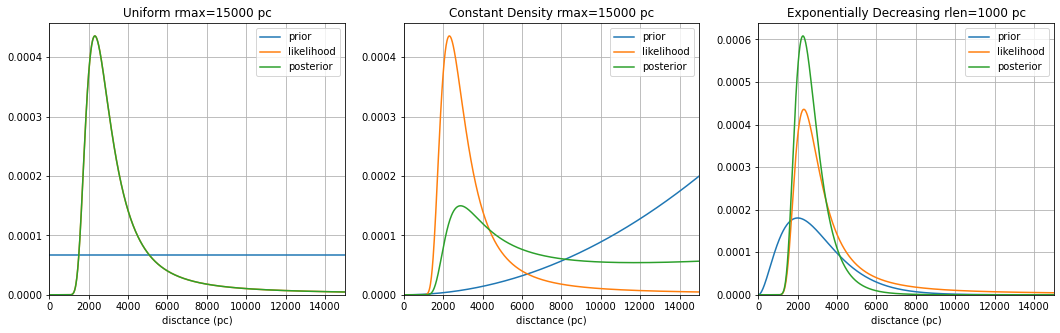

In [50]:
## Print the data that being used
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", parallax_error/parallax)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(distance, prior1, label="prior")
ax1.plot(distance, likelihood, label="likelihood")
ax1.plot(distance, posterior1, label="posterior")
ax1.legend(loc="best")
ax1.grid()
ax1.set_xlim(0, rmax)
ax1.set_ylim(0)
ax1.set_xlabel("disctance (pc)")
ax1.set_title(f"Uniform rmax={int(rmax)} pc")

ax2.plot(distance, prior2, label="prior")
ax2.plot(distance, likelihood, label="likelihood")
ax2.plot(distance, posterior2, label="posterior")
ax2.legend(loc="best")
ax2.grid()
ax2.set_xlim(0, rmax)
ax2.set_ylim(0)
ax2.set_xlabel("disctance (pc)")
ax2.set_title(f"Constant Density rmax={int(rmax)} pc")

ax3.plot(distance, prior3, label="prior")
ax3.plot(distance, likelihood, label="likelihood")
ax3.plot(distance, posterior3, label="posterior")
ax3.legend(loc="best")
ax3.grid()
ax3.set_xlim(0, rmax)
ax3.set_ylim(0)
ax3.set_xlabel("disctance (pc)")
ax3.set_title(f"Exponentially Decreasing rlen={int(rlen)} pc")

plt.show()

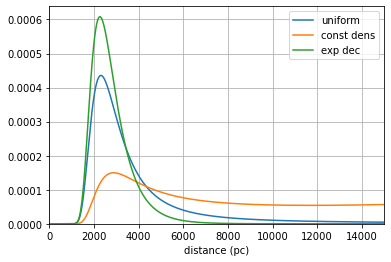

In [76]:
from scipy import interpolate
p1 = interpolate.interp1d(distance, posterior1, kind="cubic")
p2 = interpolate.interp1d(distance, posterior2, kind="cubic")
p3 = interpolate.interp1d(distance, posterior3, kind="cubic")

plt.figure(figsize=(6,4))
plt.plot(distance, p1(distance), label="uniform")
plt.plot(distance, p2(distance), label="const dens")
plt.plot(distance, p3(distance), label="exp dec")
plt.legend(loc="best")
plt.grid()
plt.xlim(0, rmax)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.show()


In [125]:
# Find percentile {perc}% of normalized distribution
def percentile(func, perc=0.5, min=0, max=1):
  r""" Find percentile {perc}% of normalized distribution
  perc: percentile
  min: min x-value
  max: max x-value
  """
  start = min
  end = rmax
  for k in range(5):
    dist = np.linspace(start, end, 10)
    for i in range(10):
      # print(dist[i])
      val, _ = integrate.quad(func, a=min, b=dist[i])
      if val > perc: break
    start = dist[i-1]
    end = dist[i]
  return (start+end)/2

In [128]:
# Highest density interval of {perc}% of normalized distribution
def hdi(func, perc=0.68, res=1E3, min=0.0, max=1.0):
  r""" Highest density interval of {perc}% of normalized distribution
  perc: percentile
  res: resolution, number of sampling from distributiion
  min: min x-value
  max: max x-value
  """
  x = np.linspace(min, max, int(res))
  y = func(x)
  upper = np.max(y)*0.99
  below = 0
  for k in range(10):
    ys = np.linspace(upper, below, 10)
    for i in range(10):
      mask = y > ys[i]
      x_mask = x[mask]
      integral, _ = integrate.quad(func, a=x_mask[0], b=x_mask[-1])
      if(integral > perc): break
    upper = ys[i-1]
    below = ys[i]
    xMin = x_mask[0]
    xMax = x_mask[-1]
  return (xMin, xMax)

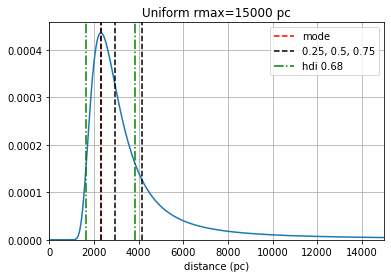

mode = 2313 pc
25% = 2314 pc
50% = 2953 pc
75% = 4140 pc
hdi = 1657-3826 pc


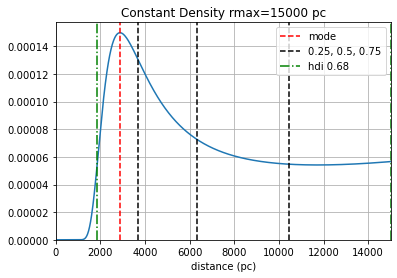

mode = 2884 pc
25% = 3704 pc
50% = 6315 pc
75% = 10440 pc
hdi = 1870-15000 pc


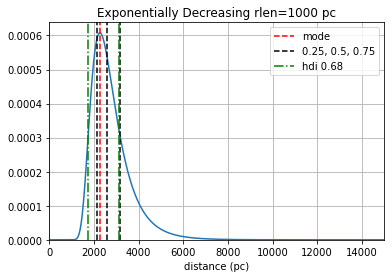

mode = 2268 pc
25% = 2148 pc
50% = 2571 pc
75% = 3162 pc
hdi = 1753-3126 pc


In [135]:
from scipy.signal import find_peaks

### Uniform
peaks, _ = find_peaks(posterior1, height=0)
mode = distance[peaks[0]]
q50 = percentile(p1, perc=0.5, min=1, max=rmax)
q25 = percentile(p1, perc=0.25, min=1, max=rmax)
q75 = percentile(p1, perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(p1, perc=hdi_perc, res=1E5, min=1.0, max=rmax)

plt.figure(figsize=(6,4))
plt.plot(distance, p1(distance))
plt.grid()
plt.xlim(0, rmax)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Uniform rmax={int(rmax)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")

### Const Dens
peaks, _ = find_peaks(posterior2, height=0)
mode = distance[peaks[0]]
q50 = percentile(p2, perc=0.5, min=1, max=rmax)
q25 = percentile(p2, perc=0.25, min=1, max=rmax)
q75 = percentile(p2, perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(p2, perc=hdi_perc, res=1E5, min=1.0, max=rmax)

plt.figure(figsize=(6,4))
plt.plot(distance, p2(distance))
plt.grid()
plt.xlim(0, rmax)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Constant Density rmax={int(rmax)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")

### Exp Dec
peaks, _ = find_peaks(posterior3, height=0)
mode = distance[peaks[0]]
q50 = percentile(p3, perc=0.5, min=1, max=rmax)
q25 = percentile(p3, perc=0.25, min=1, max=rmax)
q75 = percentile(p3, perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(p3, perc=hdi_perc, res=1E5, min=1.0, max=rmax)

plt.figure(figsize=(6,4))
plt.plot(distance, p3(distance))
plt.grid()
plt.xlim(0, rmax)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Exponentially Decreasing rlen={int(rlen)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")